#**주차 수요 분석**
# 단계1 : 데이터 전처리

## 0.미션

단지별 등록 차량 수에 영향을 미치는 요인을 분석하고자 합니다. 이에 맞게 다음의 미션을 수행하시오.
* 미션1 : 데이터 탐색하기
    * 주어진 데이터를 살펴보면서 내용을 파악합니다.
    * Target을 정의하고, 적절한 가설을 도출합니다.
* 미션2 : 데이터 종류에 따른 전처리
    * NaN을 검토하고, 조치합니다. 여기서는 준공일자(준공연도)에 대해서만 처리합니다.
    * 불필요한 칼럼을 제거합니다.
    * 분석 단위(행)를 어떻게 구성할지 고민합니다.
* 미션3 : 세부 데이터 집계 및 결합
    * 단지별 데이터와 상세 데이터를 분리하고
    * 각각에 맞는 전처리를 수행합니다.
    * 가설에 도출된 x변수를 도출하고 하나의 데이터셋으로 통합합니다.

## 1.환경설정

* 세부 요구사항
    * 제공된 압축파일을 다운받아 압축을 풀고
    * anaconda의 root directory(보통 C:/Users/< ID > 에 project2 폴더를 만들고, 복사해 넣습니다.
    * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 불러오기

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst

import joblib

### (2) 한글폰트 지정

In [9]:
import matplotlib.font_manager as fm

# 설치된 폰트
font_list = [font.name for font in fm.fontManager.ttflist]

# 맑은고딕이 있는지 확인
'Malgun Gothic' in font_list

True

In [10]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [11]:
# 유용한 함수들 모음 
def eda_1_n(data, var, bins = 30) :
    # 기초 통계량
    display(data[[var]].describe().T)

    # 시각화
    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    sns.histplot(data[var], bins = bins, kde = True)
    plt.grid()

    plt.subplot(2,1,2)
    sns.boxplot(x = data[var])
    plt.grid()
    plt.show()

# 범주형 변수에 대한 단변량 분석 함수
def eda_1_c(data, var) :
    # 기초 통계량
    print(f' <<<  {var}   >>')
    cnt = data[var].value_counts()
    prop = data[var].value_counts()/data.shape[0]
    temp = pd.DataFrame({'Class':cnt.index, 'Count':cnt.values, 'Prop':prop.values})
    display(temp)
    # 시각화
    sns.countplot(x = var, data = data)
    plt.grid()
    plt.show()

def eda_2_nn(data, feature, target) :
    # 상관분석
    result = spst.pearsonr(temp[feature], temp[target])
    print(f'상관계수 : {result[0]}, P-value : {result[1]}')

    # 산점도
    temp = data.loc[data[feature].notnull()]
    sns.scatterplot( x= feature, y = target, data = temp)
    plt.grid()
    plt.show()

def eda_2_cn(data, feature, target) :

    # 가설검정
    # 범주의 수 확인
    cat = data[feature].unique()
    n = len(cat)

    # 범주가 2개
    if n == 2 :
        g0 = data.loc[data[feature] == cat[0], target]
        g1 = data.loc[data[feature] == cat[1], target]
        result = spst.ttest_ind(g0, g1)
    else :
        result = spst.f_oneway(*[data.loc[data[feature] == c, target] for c in cat])

    print(result)

    # 시각화 : 평균비교 막대그래프
    sns.barplot(x = feature, y = target, data = data)
    plt.grid()
    plt.show()

# 상호 상관계수 구하고 시각화 하기
def eda_2_corr(data, drop_vars, viz = 0):
    # 입력
    #     * 데이터프레임(data)
    #     * 불필요한 변수(drop_vars) : 리스트
    # 출력 :
    #     * viz = 0 : 히트맵만 출력
    #     * viz = 1 : 상관계수만 출력
    #     * 그외 : 상관계수 + 히트맵

    temp = data.drop(drop_vars,axis = 1).corr()
    mask = np.zeros_like(temp)
    mask[np.triu_indices_from(mask)] = True
    mask = np.where(mask == 1, 0, 1)
    result = mask * temp
    result = result[result != 0]

    if viz == 0 :
        plt.figure(figsize = (15,12))
        sns.heatmap(result, annot = True)
        plt.show()
    elif viz == 1 :
        display(result)
    else :
        display(result)
        plt.figure(figsize = (8,8))
        sns.heatmap(result, annot = True)
        plt.show()

### (3) 경로 설정

* project2 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [14]:
path = ''

### (4) 데이터 불러오기

* 주어진 데이터셋
    * data.xlsx
    * pd.read_excel 을 이용해서 로딩합니다.

In [17]:
file = 'data.xlsx'

In [18]:
data = pd.read_excel(path + file)

## 2.미션1 : 기본 탐색

* **세부 요구사항**
    * 기본 정보 조회 : 상위 n개 조회, information, NaN 조회하기
    * 데이터 탐색하기
        * 기초통계량을 통해 각 값들의 대략의 분포를 살펴봅시다.
        * 전체 단지 수 count
        * 범주 종류 파악하기
        * 그 외 추가 탐색 하기
    * 분석 단위 결정하기
        * 주어진 데이터의 행의 의미 파악, 분석을 위한 단위 검토
    * 가설 도출
        * Target을 정의합니다.
        * 주어진 데이터를 기반으로 초기가설을 도출합니다.
            * 개인별 : 5개 이상
            * 조별 : 10개 이상

### (1) 기본 정보 조회

In [22]:
#전체 데이터의 행,열 개수 확인
data.shape

(1157, 15)

In [23]:
#전체 데이터의 상위 5개 행 확인
data.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35
3,C0002,LH삼성아파트,35,9,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35
4,C0003,강남LH8단지,88,7,서울,20131023.0,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88


In [24]:
#전체 데이터의 모든 변수 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1157 non-null   object 
 1   단지명       1157 non-null   object 
 2   총세대수      1157 non-null   int64  
 3   전용면적별세대수  1157 non-null   int64  
 4   지역        1157 non-null   object 
 5   준공일자      1103 non-null   float64
 6   건물형태      1135 non-null   object 
 7   난방방식      1082 non-null   object 
 8   승강기설치여부   1059 non-null   object 
 9   단지내주차면수   1157 non-null   int64  
 10  전용면적      1157 non-null   float64
 11  공급면적(공용)  1157 non-null   float64
 12  임대보증금     1157 non-null   int64  
 13  임대료       1157 non-null   int64  
 14  실차량수      1157 non-null   int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 135.7+ KB


In [25]:
# NaN 조사
data.isna().sum()

단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자        54
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공급면적(공용)     0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

### (2) 데이터 탐색하기
* **세부 요구사항**
    * 기초통계량을 통해 각 값들의 대략의 분포를 살펴봅시다.
    * 주어진 데이터의 행의 의미 파악, 분석을 위한 단위 검토
    * 전체 단지 수 count
    * 범주 종류 파악하기
    * 그 외 추가 탐색 하기

In [27]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수
count,1157.000000,1157.000000,1.103000e+03,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,659.075194,163.691443,1.973918e+07,682.261884,51.565584,20.562360,2.850789e+07,2.259409e+05,650.762316
std,456.110643,166.766358,2.392214e+06,473.331805,18.243315,5.164405,2.890687e+07,1.768102e+05,390.573462
min,1.000000,1.000000,2.002000e+03,10.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,21.000000
25%,315.000000,44.000000,2.004052e+07,308.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,320.000000
50%,595.000000,112.000000,2.009102e+07,629.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,626.000000
75%,918.000000,229.000000,2.013121e+07,911.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,894.000000
max,2289.000000,1258.000000,2.022071e+07,4553.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,1657.000000


In [28]:
# 단지 수 
# 최종 결과물의 행 수
data['단지코드'].nunique()

345

In [29]:
# 범주별 종류 파악하기
print('지역:', data['지역'].unique())
print('-' * 80)
print('승강기설치여부:', data['승강기설치여부'].unique())
print('-' * 80)
print('난방방식:', data['난방방식'].unique())
print('-' * 80)
print('건물형태:', data['건물형태'].unique())

지역: ['서울' '부산울산' '대구경북' '경기' '광주전남' '강원' '충북' '대전충남' '경남' '제주' '전북' '세종']
--------------------------------------------------------------------------------
승강기설치여부: ['전체동 설치' nan '일부동 설치' '미설치']
--------------------------------------------------------------------------------
난방방식: ['개별가스난방' '지역난방' nan '지역가스난방' '중앙가스난방' '개별유류난방' '중앙난방' '지역유류난방' '중앙유류난방']
--------------------------------------------------------------------------------
건물형태: ['계단식' '복도식' '혼합식' nan]


### (3) 분석 단위

In [31]:
# 분석단위는 어떻게 결정하는게 적절할까요?
# 단지별! 

## 2.미션2 : 데이터 종류에 따른 전처리

* **세부 요구사항**
    * NaN 조치
        * NaN를 다시 한번 조회합니다.
        * 준공일자만 여기서 조치합시다.
            * 준공연도만 필요합니다. 문자열로 변환한 후 앞 4자리를 잘라 준공연도로 변환합니다.
            * 잘못 들어간 데이터들과 nan 문자를 준공연도 최소값으로 치환합니다.
        * 나머지 변수들은 탐색 이후에 조치를 취합니다.
    * (필요시) 범주형 변수 통합 : 너무 많은 수의 범주를 적은 수로 통합합니다.
    * 불필요한 데이터 제거


In [34]:
# 전처리 전에 데이터셋 복사
data_copy = data.copy()

### (1) NaN 조치

In [36]:
data_copy[data_copy['준공일자'].isna()].head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수
249,C0077,일천푸른마을아파트,31,31,대구경북,NaN,복도식,개별가스난방,전체동 설치,50,62.3716,11.1220,0,0,38
250,C0078,구미화성파크드림,32,32,대구경북,NaN,계단식,개별가스난방,전체동 설치,511,84.4792,26.0459,0,0,348
252,C0080,장원하이드파크주상복합,32,1,대구경북,NaN,계단식,개별가스난방,전체동 설치,68,71.8900,13.2035,0,0,58
253,C0080,장원하이드파크주상복합,32,3,대구경북,NaN,계단식,개별가스난방,전체동 설치,68,84.0300,17.5415,0,0,58
254,C0080,장원하이드파크주상복합,32,5,대구경북,NaN,계단식,개별가스난방,전체동 설치,68,84.7300,15.9944,0,0,58


In [37]:
# 준공일자에서 준공 연도 추출하기

In [38]:
# 준공일자를 문자열로 변환(.astype('str')하고, 앞에서 4자리를 잘라서(.str.slice()) 저장
data_copy['준공연도'] = data_copy['준공일자'].astype('str').str.slice(0, 4)

# 'nan'(결측치)과 다른 이상치 처리
data_copy.loc[data_copy['준공연도'].isin(['nan', '1900','1111']), '준공연도'] = np.nan

# 준공 연도를 다시 int로 변환(.astype('int'))
data_copy['준공연도'] = data_copy['준공연도'].astype('float')  # NaN을 포함할 수 있으므로 float로 변환
data_copy['준공연도'] = data_copy['준공연도'].astype('Int64')  # Nullable integer 타입으로 변환

# 준공일자 컬럼의 NaN에 대한 조치 : 각 지역의 중앙값으로 채우기
# 경기, 서울, 대구경북 지역에 집중 => 각 지역에 해당하는 준공연도의 중앙값으로 채우기
# 각 지역의 중앙값을 저장할 딕셔너리 생성
median_year = {}

# 각 지역별로 중앙값 계산해서 딕셔너리에 저장
for region in data_copy['지역'].unique():
    median_year[region] = data_copy.loc[data_copy['지역'] ==  region, '준공연도'].median()
    
# NaN 값을 해당 지역의 중앙값으로 채우기
for region, median in median_year.items():
    data_copy.loc[(data_copy['지역'] == region) & (data_copy['준공연도'].isna()), '준공연도'] = median

# 결측치 여부 확인
data_copy['준공연도'].isna().sum()

0

In [39]:
data_copy['준공연도'].unique()

<IntegerArray>
[2013, 2014, 2011, 2007, 2012, 2018, 2010, 2008, 2009, 2017, 2016, 2019, 2015,
 1970, 2006, 2004, 2005, 2001, 1992, 1995, 2000, 1999, 1996, 1997, 1994, 1998,
 2003, 2002, 1993, 2022, 2020, 2021]
Length: 32, dtype: Int64

In [40]:
data_copy.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수,준공연도
0,C0001,엘에이치 서초4단지,78,35,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109,2013
1,C0001,엘에이치 서초4단지,78,43,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109,2013
2,C0002,LH삼성아파트,35,26,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35,2013
3,C0002,LH삼성아파트,35,9,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35,2013
4,C0003,강남LH8단지,88,7,서울,20131023.0,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88,2013


### (2) 불필요한 칼럼 제거

* **세부 요구사항**
    * 단지명 : 분석단위로 볼때 단일값.
    * 단지내주차면수 :
        * 본 문제는 등록차량수를 예측하고, 그것을 기반으로 주차면수를 정하는 것이 목적 입니다.
        * 그런데, 역으로 주차면수 먼저 정한후 그것을 기반으로 등록차량수를 예측하는 것은 성립될 수 없습니다.
    * 준공일자 : 준공연도를 사용할 것이므로, 준공일자는 제거

* 불필요한 정보 제거하기

In [44]:
data_copy.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공급면적(공용),임대보증금,임대료,실차량수,준공연도
0,C0001,엘에이치 서초4단지,78,35,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109,2013
1,C0001,엘에이치 서초4단지,78,43,서울,20131204.0,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109,2013
2,C0002,LH삼성아파트,35,26,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35,2013
3,C0002,LH삼성아파트,35,9,서울,20130801.0,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35,2013
4,C0003,강남LH8단지,88,7,서울,20131023.0,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88,2013


In [45]:
drop_cols = ['단지명', '단지내주차면수', '준공일자']
data_copy.drop(drop_cols, axis=1, inplace=True)
data_copy.head()

,단지코드,총세대수,전용면적별세대수,지역,건물형태,난방방식,승강기설치여부,전용면적,공급면적(공용),임대보증금,임대료,실차량수,준공연도
0,C0001,78,35,서울,계단식,개별가스난방,전체동 설치,51.89,19.2603,50758000,620370,109,2013
1,C0001,78,43,서울,계단식,개별가스난방,전체동 설치,59.93,22.2446,63166000,665490,109,2013
2,C0002,35,26,서울,복도식,개별가스난방,전체동 설치,27.75,16.5375,63062000,458640,35,2013
3,C0002,35,9,서울,복도식,개별가스난방,전체동 설치,29.08,17.3302,63062000,481560,35,2013
4,C0003,88,7,서울,계단식,개별가스난방,전체동 설치,59.47,21.9462,72190000,586540,88,2013


## 3.미션3 : 세부 데이터 집계 및 결합

* **세부 요구사항**

    * 데이터프레임을 두가지 형태로 나눕니다.
        * **단지별 데이터** : 중복행 제거
        * **단지내 상세 데이터** : 집계하기
    * 단지별 데이터와 상세 데이터 집계 결과 merge 시키기



### (1) 데이터프레임 두개로 나누기

* **세부 요구사항**
    * 단지별 데이터
        * 단지코드, 총세대수, 지역, 준공일자(준공연도), 건물형태, 난방방식, 승강기설치여부, 실차량수
        * 단지별 데이터를 분할 한 후, 중복행을 제거합니다.
        * 중복행이 잘 제거 되었는지 확인합니다.
    * 상세 데이터
        * 단지코드, 전용면적별세대수,전용면적, 공급면적(공용),임대보증금,임대료

In [50]:
# 단지별 데이터
complex_data = data_copy[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수']].copy()

# 확인
complex_data.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
2,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
3,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
4,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88


In [51]:
# 데이터프레임에서 중복행을 제거하기 : df.drop_duplicates()
complex_data.drop_duplicates(ignore_index=True, inplace=True)

In [52]:
# 확인 : 단지 코드가 유니크해야 함.
len(complex_data['단지코드']) == len(complex_data['단지코드'].unique())

True

* 상세 데이터

In [54]:
# 상세 데이터
detail_data = data_copy[['단지코드', '전용면적별세대수', '전용면적', '공급면적(공용)', '임대보증금', '임대료']].copy()

# 확인
detail_data.head()

,단지코드,전용면적별세대수,전용면적,공급면적(공용),임대보증금,임대료
0,C0001,35,51.89,19.2603,50758000,620370
1,C0001,43,59.93,22.2446,63166000,665490
2,C0002,26,27.75,16.5375,63062000,458640
3,C0002,9,29.08,17.3302,63062000,481560
4,C0003,7,59.47,21.9462,72190000,586540


### (2) 상세 데이터 집계하기

* **세부 요구사항**
    * 전용면적 구간으로 나누기(원래, 단변량 분석 후 구간 나누기를 결정하지만, 여기서는 현 미션에서 수행합니다.)
        * 전용면적을 의미 있는 단위로 자른 칼럼 만들기 (pd.cut)
        * 구간별 세대 수 집계(df.groupby)
        * pivot
    * 임대보증금 혹은 임대료 : 적절하게 집계하기.
        * 평균, 가중평균, 중앙값 중에서 고려하기.
    * 전체 면적을 계산합니다.(공급면적 * 세대수)
    * 그 외 가설에서 도출된 변수를 생성해 봅시다.

#### 1) 전용면적

* 전용면적을 의미있는 단위로 자른 칼럼 만들기 (pd.cut)

In [59]:
# 전용면적 구간 확인하기
def eda_1_n(data, var, bins = 30, comment=False) :
    # 기초 통계량
    print('\n', '*'*48, '<기초통계량>', '*'*48)
    display(data[[var]].describe().T)

    # 시각화
    print('\n','*'*50, '<시각화>', '*'*50)
    plt.figure(figsize = (8,6))
    plt.subplot(2,1,1)
    sns.histplot(data[var], bins = bins, kde = True)
    plt.grid()

    plt.subplot(2,1,2)
    sns.boxplot(x = data[var])
    plt.grid()
    plt.show()

    # 분석 내용 코멘트 달기
    if comment: 
        print('\n', '*'*53, '<코멘트>', '*'*53)
        input()


 ************************************************ <기초통계량> ************************************************


,count,mean,std,min,25%,50%,75%,max
전용면적,1157.0,51.565584,18.243315,17.59,39.48,46.9,59.81,139.35



 ************************************************** <시각화> **************************************************


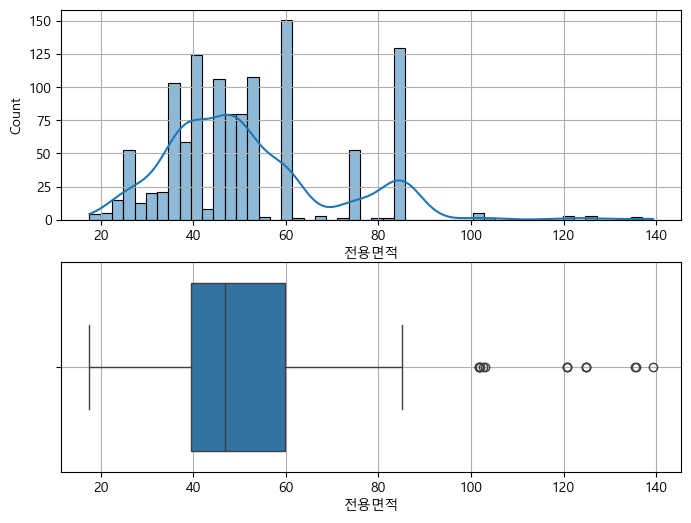

In [60]:
eda_1_n(detail_data, '전용면적', bins=50)

In [61]:
# 전용면적 나누기
label = ['전용면적_0_30', '전용면적_31_40', '전용면적_41_50', '전용면적_51_60', '전용면적_61_80', '전용면적_81_100', '전용면적_101_120', '전용면적_120+']
bin = [-np.inf, 30, 40, 50, 60, 80, 100, 120, np.inf]

# 전용면적 칼럼 생성
detail_data['전용면적cut'] = pd.cut(detail_data['전용면적'], bins=bin, labels=label)
detail_data['전용면적cut'].value_counts()

전용면적cut
전용면적_31_40      312
전용면적_51_60      287
전용면적_41_50      255
전용면적_81_100     131
전용면적_0_30        98
전용면적_61_80       59
전용면적_120+         9
전용면적_101_120      6
Name: count, dtype: int64

In [62]:
detail_data.head()

,단지코드,전용면적별세대수,전용면적,공급면적(공용),임대보증금,임대료,전용면적cut
0,C0001,35,51.89,19.2603,50758000,620370,전용면적_51_60
1,C0001,43,59.93,22.2446,63166000,665490,전용면적_51_60
2,C0002,26,27.75,16.5375,63062000,458640,전용면적_0_30
3,C0002,9,29.08,17.3302,63062000,481560,전용면적_0_30
4,C0003,7,59.47,21.9462,72190000,586540,전용면적_51_60


* 단위 칼럼별 집계

In [64]:
complex_data_group = detail_data.groupby(by=['단지코드', '전용면적cut'], observed=False, as_index=False)[['전용면적별세대수']].sum()

In [65]:
complex_data_group.head()

,단지코드,전용면적cut,전용면적별세대수
0,C0001,전용면적_0_30,0
1,C0001,전용면적_31_40,0
2,C0001,전용면적_41_50,0
3,C0001,전용면적_51_60,78
4,C0001,전용면적_61_80,0


* pivot

In [67]:
detail_data_pv = complex_data_group.pivot(index='단지코드', columns='전용면적cut', values='전용면적별세대수')

# 인덱스를 열로 가져오기 
detail_data_pv.reset_index(drop=False, inplace=True)
detail_data_pv

전용면적cut,단지코드,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+
0,C0001,0,0,0,78,0,0,0,0
1,C0002,35,0,0,0,0,0,0,0
2,C0003,0,0,0,88,0,0,0,0
3,C0004,0,0,0,150,216,111,0,0
4,C0006,15,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
340,C1341,140,0,0,0,0,0,0,0
341,C1354,1071,298,0,17,0,0,0,0
342,C2307,196,0,0,0,0,0,0,0
343,C2343,80,0,0,0,0,0,0,0


#### 2) 임대보증금, 임대료 집계 하기(평균)

In [69]:
detail_data[['임대보증금', '임대료']].describe().T

,count,mean,std,min,25%,50%,75%,max
임대보증금,1157.0,2.850789e+07,2.890687e+07,0.0,13797000.0,19973000.0,33753000.0,254922000.0
임대료,1157.0,2.259409e+05,1.768102e+05,0.0,117740.0,184290.0,263440.0,1058030.0


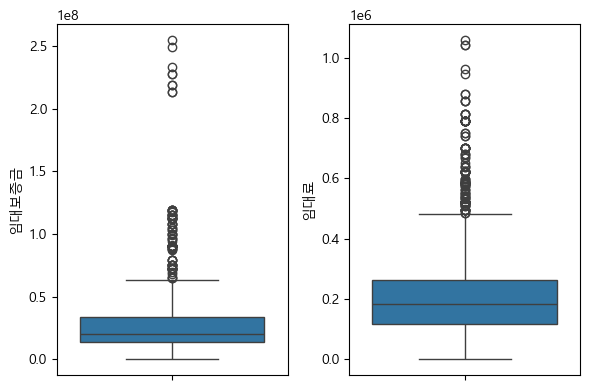

In [70]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
sns.boxplot(detail_data['임대보증금'])
plt.subplot(1, 2, 2)
sns.boxplot(detail_data['임대료'])
plt.tight_layout()
plt.show()

In [71]:
# 임대보증금과 전용면적별 세대수를 곱한 새로운 열 추가 
detail_data['전용면적별_임대보증금'] = detail_data['임대보증금'] * detail_data['전용면적별세대수']

# 단지별 임대보증금 합계
deposit_sum = detail_data.groupby(['단지코드'], as_index=False)[['전용면적별_임대보증금', '전용면적별세대수']].sum()
deposit_sum['임대보증금 평균'] = deposit_sum['전용면적별_임대보증금'] / deposit_sum['전용면적별세대수']
deposit = deposit_sum[['단지코드', '임대보증금 평균']]
deposit.head()

,단지코드,임대보증금 평균
0,C0001,5.759831e+07
1,C0002,6.306200e+07
2,C0003,7.219000e+07
3,C0004,9.158473e+07
4,C0006,5.465420e+07


In [72]:
# 임대료와 전용면적별 세대수를 곱한 새로운 열 추가 
detail_data['전용면적별_임대료'] = detail_data['임대료'] * detail_data['전용면적별세대수']

# 단지별 임대보증금 합계
rent_sum = detail_data.groupby(['단지코드'], as_index=False)[['전용면적별_임대료', '전용면적별세대수']].sum()
rent_sum['임대료 평균'] = rent_sum['전용면적별_임대료'] / rent_sum['전용면적별세대수']
rent = rent_sum[['단지코드', '임대료 평균']]
rent.head()

,단지코드,임대료 평균
0,C0001,645243.846154
1,C0002,464533.714286
2,C0003,586540.000000
3,C0004,877880.272537
4,C0006,334797.333333


#### 3) 단지별 총 면적 구하기

In [74]:
# 총 면적
detail_data['세대별총면적'] = detail_data['전용면적'] * detail_data['전용면적별세대수']

# 확인
detail_data.head()

,단지코드,전용면적별세대수,전용면적,공급면적(공용),임대보증금,임대료,전용면적cut,전용면적별_임대보증금,전용면적별_임대료,세대별총면적
0,C0001,35,51.89,19.2603,50758000,620370,전용면적_51_60,1776530000,21712950,1816.15
1,C0001,43,59.93,22.2446,63166000,665490,전용면적_51_60,2716138000,28616070,2576.99
2,C0002,26,27.75,16.5375,63062000,458640,전용면적_0_30,1639612000,11924640,721.50
3,C0002,9,29.08,17.3302,63062000,481560,전용면적_0_30,567558000,4334040,261.72
4,C0003,7,59.47,21.9462,72190000,586540,전용면적_51_60,505330000,4105780,416.29


In [75]:
# 단지별 총 면적
total_area = detail_data.groupby(['단지코드'], as_index=False)['세대별총면적'].sum()
total_area.head()

,단지코드,세대별총면적
0,C0001,4393.14
1,C0002,983.22
2,C0003,5244.69
3,C0004,34607.34
4,C0006,309.50


### (3) 합치기

* **세부 요구사항**
    * [단지별 데이터]를 기준으로 상세데이터로 만든 데이터셋을 하나씩 merge 합니다.
    * merge를 사용할 때, **how = 'left', on = '단지코드'** 옵션을 이용합니다.
        * [단지별 데이터]가 기준(left)입니다.

* 단지별 데이터 + 전용면적별 세대수

In [79]:
complex_data01 = pd.merge(complex_data, detail_data_pv, how='left', on='단지코드')
complex_data01.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,0
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,0
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,0
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,216,111,0,0
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,0


* 평균 임대 보증금/임대료 합치기

In [81]:
complex_data02 = pd.merge(complex_data01, deposit, how='left', on='단지코드')
complex_data02.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,0,5.759831e+07
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,0,6.306200e+07
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,0,7.219000e+07
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,216,111,0,0,9.158473e+07
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,0,5.465420e+07


In [82]:
complex_data03 = pd.merge(complex_data02, rent, how='left', on='단지코드')
complex_data03.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균,임대료 평균
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,0,5.759831e+07,645243.846154
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,0,6.306200e+07,464533.714286
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,0,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,216,111,0,0,9.158473e+07,877880.272537
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,0,5.465420e+07,334797.333333


In [83]:
complex_data04 = pd.merge(complex_data03, total_area, how='left', on='단지코드')
complex_data04.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균,임대료 평균,세대별총면적
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,0,5.759831e+07,645243.846154,4393.14
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,0,6.306200e+07,464533.714286,983.22
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,0,7.219000e+07,586540.000000,5244.69
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,216,111,0,0,9.158473e+07,877880.272537,34607.34
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,0,5.465420e+07,334797.333333,309.50


### (4) 추가 변수 만들기
* 가설에서 도출된 변수를 추가로 도출하고, 기존 데이터셋에 추가해 봅시다.

##### ⓛ 해당지역의 대중교통 이용량은 가구당 자동차 보유 수와 관련이 있을 것이다

In [86]:
# 지역 확인
complex_data02['지역'].unique()

array(['서울', '부산울산', '대구경북', '경기', '광주전남', '강원', '충북', '대전충남', '경남', '제주',
       '전북', '세종'], dtype=object)

In [87]:
# 행 갯수 확인용 열 추가
complex_data02['count'] = 1

In [88]:
# 지역별 집계
complex_data03 = complex_data02.groupby(by='지역')[['count', '총세대수', '실차량수']].sum()

In [89]:
# 한국교통안전공단_전국 지역별 대중교통 이용 및 환승실태
k_pm = pd.read_csv('한국교통안전공단_전국 지역별 대중교통 이용 및 환승실태_20231231.csv', encoding='cp949', index_col='구분1')
k_pm.head()

,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
구분1,,,,,,,,,,,,,,,,,
1주간대중교통이용횟수(회),9.92,9.72,9.96,9.64,9.65,9.57,9.55,9.37,9.67,9.25,9.41,9.43,9.22,9.33,9.38,9.35,9.20
한달평균대중교통비용(원),"50,125","50,079","49,998","49,715","50,508","50,940","50,066","50,097","51,317","51,033","49,770","50,400","50,666","51,165","51,246","50,634","50,554"
주이용교통수단_버스(%),31.5,55.1,55.9,49.5,81.9,76.9,100.0,100.0,62.0,98.3,100.0,93.5,100.0,100.0,97.5,94.5,100.0
주이용교통수단_도시철도(%),68.5,44.9,44.1,50.5,18.1,23.1,0,0,38.0,1.7,0,6.5,0,0,2.5,5.5,0
교통카드이용률(%),100,99.7,99.6,99.7,98.9,99.6,99.7,99.9,99.1,90.2,91.6,92.5,94.2,85.1,88.5,92.5,99.0


In [90]:
# 1주간 대중교통 이용횟수를 이용량으로 가정하고 해당 행만 추출
k_pm_use = k_pm[:1].copy()
k_pm_use = k_pm_use.astype('float')

In [91]:
# '서울', '부산울산', '대구경북', '경기', '광주전남', '강원', '충북', '대전충남', '경남', '제주', '전북', '세종'
k_pm_use['부산울산'] = (k_pm_use['부산'] + k_pm_use['울산']) / 2 
k_pm_use['대구경북'] = (k_pm_use['대구'] + k_pm_use['경북']) / 2 
k_pm_use['광주전남'] = (k_pm_use['광주'] + k_pm_use['전남']) / 2 
k_pm_use['대전충남'] = (k_pm_use['대전'] + k_pm_use['충남']) / 2 

kpm_df = k_pm_use[['서울', '부산울산', '대구경북', '경기', '광주전남', '강원', '충북', '대전충남', '경남', '제주', '전북', '세종']].copy().transpose()
kpm_df = kpm_df.reset_index().rename(columns = {'index':'지역', '1주간대중교통이용횟수(회)': '지역주간대중교통이용횟수'})
kpm_df

구분1,지역,지역주간대중교통이용횟수
0,서울,9.920
1,부산울산,9.635
2,대구경북,9.670
3,경기,9.670
4,광주전남,9.490
5,강원,9.250
6,충북,9.410
7,대전충남,9.500
8,경남,9.350
9,제주,9.200


In [92]:
complex_data04 = pd.merge(complex_data03, kpm_df, how='left', on='지역')[['지역', '지역주간대중교통이용횟수']]
complex_data04.head()

,지역,지역주간대중교통이용횟수
0,강원,9.25
1,경기,9.67
2,경남,9.35
3,광주전남,9.49
4,대구경북,9.67


In [93]:
# 기존데이터셋과 합치기
complex_data05 = pd.merge(complex_data02, complex_data04, how='left', on='지역')

# 확인
complex_data05

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균,count,지역주간대중교통이용횟수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,0,5.759831e+07,1,9.92
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,0,6.306200e+07,1,9.92
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,0,7.219000e+07,1,9.92
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,216,111,0,0,9.158473e+07,1,9.92
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,0,5.465420e+07,1,9.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298,1181,298,0,6,0,0,0,0,6.978992e+06,1,9.50
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258,1071,298,0,17,0,0,0,0,6.091478e+06,1,9.50
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243,956,0,0,0,0,0,0,0,9.931000e+06,1,9.67
343,C0358,120,강원,2020,복도식,NaN,전체동 설치,47,66,54,0,0,0,0,0,0,2.476850e+06,1,9.25


In [94]:
complex_data05.columns

Index(['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수',
       '전용면적_0_30', '전용면적_31_40', '전용면적_41_50', '전용면적_51_60', '전용면적_61_80',
       '전용면적_81_100', '전용면적_101_120', '전용면적_120+', '임대보증금 평균', 'count',
       '지역주간대중교통이용횟수'],
      dtype='object')

In [95]:
data.columns

Index(['단지코드', '단지명', '총세대수', '전용면적별세대수', '지역', '준공일자', '건물형태', '난방방식',
       '승강기설치여부', '단지내주차면수', '전용면적', '공급면적(공용)', '임대보증금', '임대료', '실차량수'],
      dtype='object')

##### ② 임대료와 임대보증금의 합이 높은 곳일수록 보유한 자동차 수가 많을 것이다

In [97]:
# total_fee = 임대보증금 + 임대료
complex_data05['total_fee'] = data['임대보증금'] + data['임대료']

# 확인
complex_data05.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,전용면적_41_50,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균,count,지역주간대중교통이용횟수,total_fee
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,0,78,0,0,0,0,5.759831e+07,1,9.92,51378370
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,0,0,0,0,0,0,6.306200e+07,1,9.92,63831490
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,0,88,0,0,0,0,7.219000e+07,1,9.92,63520640
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,0,150,216,111,0,0,9.158473e+07,1,9.92,63543560
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,0,0,0,0,0,0,5.465420e+07,1,9.92,72776540


<Axes: ylabel='Frequency'>

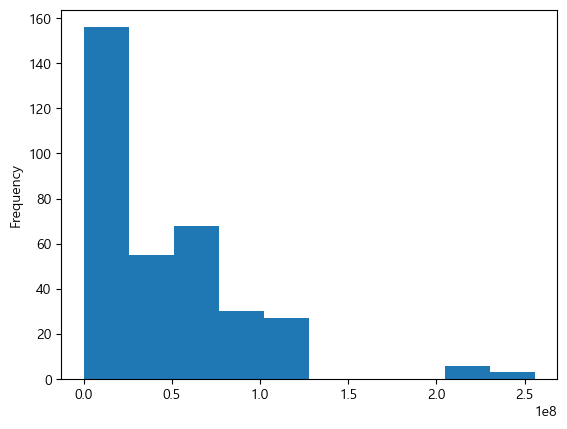

In [98]:
complex_data05['total_fee'].plot(kind='hist')

##### ③ 총면적 / total_fee 를 하면 찐 부자들을 걸러낼 수 있을지도 몰라?!

In [100]:
# price_per_area = 총면적 / total_fee
complex_data05['price_per_area'] = detail_data['세대별총면적'] / complex_data05['total_fee']

# 확인
complex_data05.head()

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,...,전용면적_51_60,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균,count,지역주간대중교통이용횟수,total_fee,price_per_area
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,...,78,0,0,0,0,5.759831e+07,1,9.92,51378370,0.000035
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,...,0,0,0,0,0,6.306200e+07,1,9.92,63831490,0.000040
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,...,88,0,0,0,0,7.219000e+07,1,9.92,63520640,0.000011
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,...,150,216,111,0,0,9.158473e+07,1,9.92,63543560,0.000004
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,...,0,0,0,0,0,5.465420e+07,1,9.92,72776540,0.000006


In [101]:
complex_data05['price_per_area'].describe()

C:\Users\User\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


count    3.450000e+02
mean              inf
std               NaN
min      4.042142e-07
25%      6.045354e-05
50%      2.187654e-04
75%               NaN
max               inf
Name: price_per_area, dtype: float64

In [102]:
# inf는 분모에 0이 들어가서,, 
data[['임대료', '임대보증금']].describe() #0따리가 포함되어있는 것을 알 수 있슴 그럼 삭제하고 하냐? ㄴㄴ 일단 keep going~ 0 아닌 값만 보면 댐

,임대료,임대보증금
count,1.157000e+03,1.157000e+03
mean,2.259409e+05,2.850789e+07
std,1.768102e+05,2.890687e+07
min,0.000000e+00,0.000000e+00
25%,1.177400e+05,1.379700e+07
50%,1.842900e+05,1.997300e+07
75%,2.634400e+05,3.375300e+07
max,1.058030e+06,2.549220e+08


##### ④ 대단지는 주변에 학군, 상가 등이 밀집 되어있을 것으로 예상해볼 수 있음. 세대수 기준으로 대중소를 나눠보자.

통상 대단지의 경우 1000세대 이상 아파트를 칭하며

500 ~ 999세대까지 중형단지

499세대 미만은 소형단지

세대수가 많아도 1동으로 되어있는 아파트는 나홀로아파트로 칭합니다.

-구자균 공인중개사님의 답변 ,,

In [105]:
complex_data05[['총세대수']].describe().T

,count,mean,std,min,25%,50%,75%,max
총세대수,345.0,546.75942,432.359538,1.0,178.0,491.0,853.0,2289.0


In [106]:
bin = [0, 500, 1000, np.inf] # 0이상~500미만, 500이상~1000미만
label = ['소형단지', '중형단지', '대단지']

complex_data05['단지구분'] = pd.cut(complex_data05['총세대수'], bins=bin, labels=label)

# 확인
display(complex_data05.head())
display(complex_data05['단지구분'].value_counts())

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,전용면적_0_30,전용면적_31_40,...,전용면적_61_80,전용면적_81_100,전용면적_101_120,전용면적_120+,임대보증금 평균,count,지역주간대중교통이용횟수,total_fee,price_per_area,단지구분
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,0,0,...,0,0,0,0,5.759831e+07,1,9.92,51378370,0.000035,소형단지
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,35,0,...,0,0,0,0,6.306200e+07,1,9.92,63831490,0.000040,소형단지
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,0,0,...,0,0,0,0,7.219000e+07,1,9.92,63520640,0.000011,소형단지
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,0,0,...,216,111,0,0,9.158473e+07,1,9.92,63543560,0.000004,소형단지
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,15,0,...,0,0,0,0,5.465420e+07,1,9.92,72776540,0.000006,소형단지


단지구분
소형단지    179
중형단지    120
대단지      46
Name: count, dtype: int64

## 4.데이터셋 저장하기

* **세부 요구사항**
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [109]:
import joblib
joblib.dump(complex_data05, 'complex_data_total.pkl')

['complex_data_total.pkl']

In [110]:
import joblib

joblib.dump(base_data, path + 'base_data.pkl')

NameError: name 'base_data' is not defined